In [43]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [44]:
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")


In [45]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple
import matplotlib.pyplot as plt
import math
import galois
import itertools
import os    
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
from sklearn.cluster import SpectralClustering
import networkx as nx

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'



In [46]:
class Decoder:
    
    def __init__ (self,H, num_iter,cluster_size,clusters):
        # code parameters
        self.n = H.shape[1]
        self.k = self.n - H.shape[0]
        self.H = H
        self.num_iter = num_iter
        
        # misc parameters (epsilon : for numerical stability)
        self.ep = 1e-5
        
        # graph parameters
        self.num_VN = self.n
        self.num_CN = self.n-self.k
        self.cluster_size = cluster_size
        
        # adjacency list for VN and CN
        self.CN = []
        self.VN = []
        self.construct_graph(H)
        if clusters is None:
            self.initialize_clusters(self.cluster_size)
        else:
            self.num_clusters = math.ceil(self.num_CN/cluster_size)
            self.MI = np.zeros(self.num_clusters) # for storing current MI of clusters
            self.clusters = clusters
        self.iteration_number = 0
        self.policy = None # policy for choosing clusters (using RL)
        
    # build the adjacency list for Tanner Graph
    def construct_graph(self,H):
        for i in range(self.num_CN):
            temp = []
            for j in range(self.num_VN):
                if H[i,j]==1:
                    temp.append(j)
            self.CN.append(temp)
            
        for i in range(self.num_VN):
            temp = []
            for j in range(self.num_CN):
                if H[j,i]==1:
                    temp.append(j)
            self.VN.append(temp)
    
    # print the tanner graph
    def print_graph(self,mode):
        if mode=="matrix":
            print(self.H)
        elif mode=="list":
            print('CN : ',self.CN)
            print('VN : ',self.VN)
        else:
            print('Invalid mode')
    
    
    # initialize clusters of CNs
    def initialize_clusters(self,cluster_size):
        self.num_clusters = math.ceil(self.num_CN/cluster_size)
        self.MI = np.zeros(self.num_clusters) # for storing current MI of clusters

        self.clusters = []
        for i in np.arange(0,self.num_CN,cluster_size):
            temp = []
            for j in range(i,min(i+cluster_size,self.num_CN)):
                temp.append(j)
            self.clusters.append(temp)  
            

                    
    # returns the absolute min, 2nd min and parity of the input array
    def get_min(self,arr):
        arr = np.array(arr)
        arr = arr[~np.isnan(arr)]
        parity = np.prod(np.sign(arr))
        if len(arr) < 2:
            print("arr = ",arr)
            raise ValueError("Not enough valid elements in the array.")
        arr = np.sort(np.abs(arr))
        return arr[0],arr[1],parity
    
    # perform row update of cluster a 
    def row_update(self,a):
        # subtract step (removing known beliefs)
        for j in range(self.num_VN):
            tot = 0
            for i in self.clusters[a]:
                if not np.isnan(self.L[i,j]):
                    tot = tot + self.L[i,j]
            self.sum[j] = self.sum[j] - tot

        # flow down the sum into the cluster a
        for j in range(self.num_VN):
            for i in self.clusters[a]:
                if not np.isnan(self.L[i,j]):
                    self.L[i,j] = self.sum[j]

        # perform minsum for each row
        for i in self.clusters[a]:
            m1,m2,p = self.get_min(self.L[i])
            for j in range(self.num_VN):
                if not np.isnan(self.L[i,j]):
                    self.L[i,j] = p*np.sign(self.L[i,j])*m2 if np.abs(self.L[i,j])==m1 else p*np.sign(self.L[i,j])*m1

    def col_update(self,a):
        for j in range(self.num_VN):
            tot = 0
            for i in self.clusters[a]:
                if not np.isnan(self.L[i,j]):
                    tot = tot + self.L[i,j]
            self.sum[j] = self.sum[j] + tot
            
    def pseudo_row_update(self,a):
        # subtract step (removing known beliefs)
        p_L = self.L
        p_sum = self.sum
        
        for j in range(self.num_VN):
            tot = 0
            for i in self.clusters[a]:
                if not np.isnan(p_L[i,j]):
                    tot = tot + p_L[i,j]
            p_sum[j] = p_sum[j] - tot

        # flow down the sum into the cluster a
        for j in range(self.num_VN):
            for i in self.clusters[a]:
                if not np.isnan(p_L[i,j]):
                    p_L[i,j] = p_sum[j]

        # perform minsum for each row
        for i in self.clusters[a]:
            m1,m2,p = self.get_min(p_L[i])
            for j in range(self.num_VN):
                if not np.isnan(p_L[i,j]):
                    p_L[i,j] = p*np.sign(p_L[i,j])*m2 if np.abs(p_L[i,j])==m1 else p*np.sign(p_L[i,j])*m1
        
        return p_L, p_sum

    def pseudo_col_update(self, a, p_L, p_sum):
        for j in range(self.num_VN):
            tot = 0
            for i in self.clusters[a]:
                if not np.isnan(p_L[i,j]):
                    tot = tot + p_L[i,j]
            p_sum[j] = p_sum[j] + tot
        
        return p_L


#     def decode(self,y,verbose="off",scheduling="round-robin"):
#         # sum is initialized by incoming beliefs (initial LLRs)
#         self.sum = y
        
#         # initializing the storage matrix
#         self.L = np.full(self.H.shape, np.nan, dtype=float)  # Initialize with NaNs
#         for i in range(self.num_CN):
#             for j in range(self.num_VN):
#                 self.L[i,j] = 0 if self.H[i,j]==1 else np.nan
        
# #         # initial MI approximation
# #         self.MI = self.get_MI(self.L)
        
#         for k in range(self.num_iter):
#             self.MI = self.get_MI(self.L)
#             self.iteration_number = k
#             a = self.get_next_cluster(k,scheduling)
#             if verbose=="on":
#                 print("Iteration : ",k,"\tCluster scheduled : ",a)
#             self.row_update(a)
#             self.col_update(a)
#             c_hat = np.array([1 if val<0 else 0 for val in self.sum])
#             if self.stopping_criteria(k,c_hat):
#                 break
#         return c_hat
    
    def get_MI(self,L):
        var = np.zeros(self.num_clusters)
        for a in range(self.num_clusters):
            total = 0
            count = 0
            for i in self.clusters[a]:
                for j in self.CN[i]:
                    total = total + np.abs(L[i,j])
                    count = count + 1
            mean = total/count
            var[a] = mean*2
        
        MI = np.zeros(self.num_clusters)
        for a in range(self.num_clusters):
            MI[a] = self.J(var[a])
        
        return MI

        
    def J(self,sigma):
        # constants
        a_J1 = -0.0421061
        b_J1 = 0.209252
        c_J1 = -0.00640081

        a_J2 = 0.00181491
        b_J2 = -0.142675
        c_J2 = -0.0822054
        d_J2 = 0.0549608

        # threshold sigma*
        sigma_star = 1.6363
        
        if 0 <= sigma <= sigma_star:
            return a_J1 * sigma**3 + b_J1 * sigma**2 + c_J1 * sigma
        elif sigma_star < sigma < 10:
            exponent = a_J2 * sigma**3 + b_J2 * sigma**2 + c_J2 * sigma + d_J2
            return 1 - math.exp(exponent)
        else:  # sigma >= 10
            return 1

            
        
    def stopping_criteria(self,k,c_hat):
        c1 = k>self.num_iter
        c2 = (np.sum(np.dot(self.H,c_hat.T)%2)==0)
        return c1 or c2
    
    # calculates the difference between information metrics for cluster a
    def calculate_residual(self, info, info_new, a):
        return info_new[a] - info[a]
    
    def get_next_cluster(self,iter_number,scheduling):
        # round robin
        if scheduling=="round-robin":
            return (iter_number%self.num_clusters)
        
        elif scheduling=="residual-llr":
            llr_gains = np.zeros(self.num_clusters)
            for a in range(self.num_clusters):
                p_L, p_sum = self.pseudo_row_update(a)
                max_diff = -100000
                for j in self.CN[a]:
                    max_diff = max(np.abs(self.L[a,j]-p_L[a,j]),max_diff)
                llr_gains[a] = max_diff
            return np.argmax(llr_gains)
                
    
        # Information Gain
        MI_gains = np.zeros(self.num_clusters)
        for a in range(self.num_clusters):
            p_L, p_sum = self.pseudo_row_update(a)
            p_L = self.pseudo_col_update(a,p_L,p_sum)
            MI_new = self.get_MI(p_L)
            gain = self.calculate_residual(self.MI, MI_new, a)
            MI_gains[a] = gain
            
        a = np.argmax(MI_gains)
        return a
        
    
        

## Q-network architecture

- Input to the Neural Network : Number of states (length of the code)
- Output of the network : Number of actions (number of clusters)
- Both determined by the Decoder

In [47]:
# Define the neural network architecture
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, action_dim)

        # Explicit weight initialization
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc1.bias)
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_uniform_(self.fc3.weight)  # Output layer: Xavier Uniform for final layer
        nn.init.zeros_(self.fc3.bias)


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Replay Buffer

In [48]:
# Define the replay buffer class
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []

    def push(self, transition):
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return batch

## DQN Agent Class

In [49]:
# Define the DQN agent class
class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=0.01, gamma=0.99, epsilon=1.0, epsilon_decay=0.8, epsilon_min=0.01, batch_size=64, buffer_size=1000):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        # parameters for Q-learning
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        
        # initializing networks and replay-buffer
        self.memory = ReplayBuffer(buffer_size)
        self.policy_net = DQN(self.state_dim, self.action_dim).to(self.device)
        self.target_net = DQN(self.state_dim, self.action_dim).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        # loss for the networks
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.target_optimizer = optim.Adam(self.target_net.parameters(), lr=lr)
        self.epsilon_decay_list = []  # List to store epsilon values

    # chooses either (a)random action OR (b)policy action based on epsilon greedy exploration
    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.action_dim)
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                q_values = self.policy_net(state)
                return q_values.max(1)[1].item()

    # memorizes the experience into the replay buffer
    def memorize(self, state, action, reward, next_state, done):
        self.memory.push((state, action, reward, next_state, done))


    # function to perform back-propogation using the batch sampled frim replay-buffer
    def train_agent(self, timestep):
        if len(self.memory.buffer) < self.batch_size:
            return

        # Sample a batch from the replay buffer
        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)

        # Compute Q-values for the current states and selected actions
        current_q_values = self.policy_net(states).gather(1, actions)

        # Compute target Q-values using the target network
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0].unsqueeze(1)
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        # Calculate the loss using the Huber loss function
        loss = F.smooth_l1_loss(current_q_values, target_q_values.detach())

        # Perform backward pass and update weights of the policy network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Perform epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            self.epsilon_decay_list.append(self.epsilon)

        # Periodically update the target network weights to the policy network weights
        if timestep % 100 == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())



## Environment for the Agent 

In [50]:
def simulate_environment(dec, state, action, c, eps=1e-5):
    """
    dec - decoder instance
    state - vector of LLRs of all the VNs
    action - cluster number to be scheduled
    c - actual codeword (to be used to calculate reward)
    """
    # take action on the decoder (schedule cluster 'action') and update the state
    dec.row_update(action)
    dec.col_update(action)
    
    # find the new state 
    new_state = dec.sum
    
    # get the reward (define reward function here)
    c_hat = np.array([1 if val<0 else 0 for val in new_state])
    error = np.sum((c_hat+c)%2)/len(c)
    reward = 1/(error+eps)
    
    return new_state, reward
    
    


In [51]:

def cluster_cns_min_cycles(H, cluster_size):
    """
    Assign CNs to clusters to minimize cycles between clusters.

    Parameters:
    - H: Adjacency matrix (numpy array) representing the Tanner graph (CNs on x-axis, VNs on y-axis).
    - cluster_size: Maximum size of each cluster.

    Returns:
    - clusters: A list of clusters, where each cluster is a list of CN indices.
    """
    num_CN, num_VN = H.shape

    # Step 1: Build a CN-to-CN adjacency matrix based on shared VNs
    CN_adj_matrix = np.zeros((num_CN, num_CN), dtype=int)
    for vn in range(num_VN):
        # Find all CNs connected to this VN
        connected_cns = np.where(H[:, vn] != -1)[0]
        for i in connected_cns:
            for j in connected_cns:
                if i != j:
                    CN_adj_matrix[i, j] += 1  # Count shared VN connections

    # Step 2: Apply clustering (Spectral Clustering)
    num_clusters = int(np.ceil(num_CN / cluster_size))  # Determine number of clusters
    clustering = SpectralClustering(
        n_clusters=num_clusters,
        affinity="precomputed",
        random_state=42,
    )
    cluster_labels = clustering.fit_predict(CN_adj_matrix)

    # Step 3: Group CNs by cluster labels
    clusters = [[] for _ in range(num_clusters)]
    for cn, label in enumerate(cluster_labels):
        clusters[label].append(cn)

    return clusters



In [52]:
def visualize_tanner_graph(H, clusters):
    """
    Visualize the bipartite Tanner graph.

    Parameters:
    - H: Adjacency matrix (numpy array) representing the Tanner graph.
    - clusters: List of lists where each inner list contains the indices of check nodes in a cluster.
    """
    num_check_nodes, num_variable_nodes = H.shape
    
    # Create the bipartite graph
    G = nx.Graph()

    # Add nodes for check nodes (CNs) and variable nodes (VNs)
    for i in range(num_check_nodes):
        G.add_node(f"CN{i}", bipartite=0)  # Left side
    for j in range(num_variable_nodes):
        G.add_node(f"VN{j}", bipartite=1)  # Right side

    # Add edges based on the H matrix
    for i in range(num_check_nodes):
        for j in range(num_variable_nodes):
            if H[i, j] != 0:  # Edge exists if the value in H is not -1
                G.add_edge(f"CN{i}", f"VN{j}")

    # Position the nodes for visualization
    pos = {}
    # Place CNs on the left and VNs on the right
    i = 0
    for c in clusters:
        for ind in c:
            pos[f"CN{ind}"] = (0,-i)
            i = i + 1
    # for i in range(num_check_nodes):
    #     pos[f"CN{i}"] = (0, -i)  # Left side
    for j in range(num_variable_nodes):
        pos[f"VN{j}"] = (2, -j)  # Right side

    # Draw the graph
    plt.figure(figsize=(12, 8))
    colors = ["red", "blue", "green", "orange", "purple", "cyan", "yellow", "pink"]

    # Draw CNs with different colors for different clusters
    for cluster_idx, cluster in enumerate(clusters):
        cluster_color = colors[cluster_idx % len(colors)]
        nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=[f"CN{i}" for i in cluster],
            node_color=cluster_color,
            node_size=600,
            label=f"Cluster {cluster_idx}"
        )

    # Draw VNs with a single color
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=[f"VN{j}" for j in range(num_variable_nodes)],
        node_color="gray",
        node_size=600,
        label="Variable Nodes",
    )

    # Draw edges
    # Draw edges with colors corresponding to the CN they originate from
    edge_colors = []
    for u, v in G.edges():
        if u.startswith("CN"):  # Edge originates from a CN
            cn_index = int(u[2:])  # Extract CN index
            for cluster_idx, cluster in enumerate(clusters):
                if cn_index in cluster:
                    edge_colors.append(colors[cluster_idx % len(colors)])  # Use the CN's cluster color
                    break
        else:
            edge_colors.append("black")  # Default color if edge does not originate from a CN

    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, alpha=0.7)

    # Add labels to nodes
    labels = {f"CN{i}": f"CN{i}" for i in range(num_check_nodes)}
    labels.update({f"VN{j}": f"VN{j}" for j in range(num_variable_nodes)})
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color="white")

    # Add legend
    plt.legend(scatterpoints=1)
    plt.title("Bipartite Tanner Graph")
    plt.axis("off")
    plt.show()


In [76]:
def circular_shift_identity(z, k):
    """
    Generate a z x z identity matrix with circularly shifted rows by k positions.
    If k == -1, return a z x z zero matrix.
    """
    if k == -1:
        return np.zeros((z, z), dtype=int)
    else:
        return np.roll(np.eye(z, dtype=int), -k, axis=1)

def expand_base_matrix(B, z):
    """
    Expand the base matrix B into the full parity check matrix with expansion factor z.

    B: Base matrix of size m x n
    z: Expansion factor

    Returns the expanded parity-check matrix of size (m*z) x (n*z).
    """
    m, n = B.shape
    H = np.zeros((m * z, n * z), dtype=int)  # Full parity check matrix initialized to zeros

    for i in range(m):
        for j in range(n):
            # Expand each base matrix element into a z x z block
            block = circular_shift_identity(z, B[i, j])
            H[i * z:(i + 1) * z, j * z:(j + 1) * z] = block

    return H

def get_codewords(H):
    GF = galois.GF(2)
    A = GF(H)
    N = A.null_space()
    vec = [np.array(v) for v in itertools.product([0, 1], repeat=N.shape[0])]
    C = np.array(GF(vec) @ N)
    return C

# B = np.loadtxt('./base_matrices/NR_1_6_13.txt', dtype=int)
# print("Shape of B : ",B.shape)

# H = expand_base_matrix(B=B,z=13)
# print("Shape of H : ",H.shape)
H = np.array( [[0,0,1,1,0,0,1,0,0,0,0,0,0,0,0]
,[1,0,0,0,1,0,0,1,0,0,0,0,0,0,0]
,[0,1,0,0,0,1,0,0,1,0,0,0,0,0,0]
,[1,0,0,0,0,1,1,0,0,0,0,0,0,0,0]
,[0,1,0,1,0,0,0,1,0,0,0,0,0,0,0]
,[0,0,1,0,1,0,0,0,1,0,0,0,0,0,0]
,[1,0,0,1,0,0,0,0,1,0,0,0,0,0,0]
,[0,1,0,0,1,0,1,0,0,0,0,0,0,0,0]
,[0,0,1,0,0,1,0,1,0,0,0,0,0,0,0]
,[1,0,0,1,0,0,1,0,0,1,0,0,1,0,0]
,[0,1,0,0,1,0,0,1,0,0,1,0,0,1,0]
,[0,0,1,0,0,1,0,0,1,0,0,1,0,0,1]],dtype=int)

# n = H.shape[1]
# C = get_codewords(H)
# C = np.array(C)
# dmin = np.min(np.sum(C[1:],axis=1))

# random sparse base matrix
# B = np.array([[0,2,-1,3,-1,-1,2,4,1,0],
#             [3,1,-1,-1,0,0,1,2,3,0],
#             [1,0,0,-1,1,4,2,1,0,-1],
#             [-1,0,0,2,3,-1,-1,-1,0,-1],
#             [1,0,2,0,1,0,-1,-1,-1,-1],
#             [2,1,0,0,2,-1,-1,-1,1,-1]]
#             ,dtype=int)

# # sparse base matrix ensuring double diaognal structure like in 5GNR LDPC
# B = np.array([  [0, 2, -1, 3, 0, 0,-1, -1, -1, -1],
#                 [3, 1, -1,-1, 1, 0, 0, -1, -1, -1],
#                 [1, -1, 2, -1, 0,-1, 0, -1, -1, -1],
#                 [-1, 1, -1, 2, 3, -1,-1,  0, -1, -1],
#                 [2, -1, 2, 0, -1,  0,-1, -1,  0, -1],
#                 [1, -1, 4, 0, 2, -1, 3, -1, -1,  0]]
#                 ,dtype=int)

# # generated from chatgpt (high dmin B with sparse LDPC structure)
# B = np.array([
#     [0, 1, -1, -1, -1, -1, -1, -1, -1, -1],
#     [-1, 0, 2, -1, -1, -1, -1, -1, -1, -1],
#     [1, -1, -1, 3, -1, 4, -1, -1, -1, -1],
#     [-1, 2, -1, -1, 5, -1, 6, -1, -1, -1],
#     [3, -1, 4, -1, -1, -1, -1, 7, -1, -1],
#     [-1, 5, -1, 6, -1, -1, -1, -1, 0, -1],
#     [6, -1, -1, 7, -1, -1, -1, -1, -1, 1],
#     [-1, -1, 7, -1, -1, -1, 0, -1, 1, 2]
# ])

B = np.array([
    [0, 1, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, 0, 1, -1, -1, -1, -1, -1, -1, -1],
    [1, -1, 2, -1, 3, -1, 4, -1, 5, -1],
    [-1, 2, -1, 3, -1, 4, -1, 5, -1, 0],
    [3, -1, 4, -1, 5, -1, 0, -1, 1, -1],
    [-1, 4, -1, 5, -1, 0, -1, 1, -1, 2],
    [5, -1, 0, -1, 1, -1, 2, -1, 3, -1],
    [-1, 0, -1, 1, -1, 2, -1, 3, -1, 4]
])


# B = np.array([
#     [0, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
#     [-1, 0, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
#     [1, -1, 2, -1, 3, -1, 4, -1, -1, -1, -1, -1],
#     [-1, 2, -1, 3, -1, 4, -1, 5, -1, 0, -1, -1],
#     [3, -1, 4, -1, 5, -1, 0, -1, 1, -1, -1, 0],
#     [-1, 4, -1, 5, -1, 0, -1, 1, -1, 1, -1, 1],
#     [5, -1, 0, -1, 1, -1, 2, -1, 3, -1, 1, -1],
#     [-1, 0, -1, 1, -1, 2, -1, 3, -1, 4, 0, -1],
#     [-1, 0, 2, -1, -1, 1, 0, -1, -1, 0, -1, 0],
#     [-1, -1, -1, 1, -1, 0, -1, -1, 3, -1, -1, -1]
# ])


# B = np.array([[2,-1,3],
#              [-1,4,-1],
#              [0,-1,5]],dtype=int)

print("B = \n",B)
z = 5

H = expand_base_matrix(B,z)
np.savetxt('output.txt',H,fmt="%d")
print("H : \n",H)

C = get_codewords(H)
print("Codewords : \n",C)
print(len(C)," codewords found")
dmin = np.min(np.sum(C[1:],axis=1))
print("dmin = ",dmin)

print("Shape of H : ",H.shape)
# num_iter = 100
# dec = Decoder(H,"bsc",0,num_iter,3)


B = 
 [[ 0  1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  0  1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1  2 -1  3 -1  4 -1  5 -1]
 [-1  2 -1  3 -1  4 -1  5 -1  0]
 [ 3 -1  4 -1  5 -1  0 -1  1 -1]
 [-1  4 -1  5 -1  0 -1  1 -1  2]
 [ 5 -1  0 -1  1 -1  2 -1  3 -1]
 [-1  0 -1  1 -1  2 -1  3 -1  4]]
H : 
 [[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]]
Codewords : 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 0 0 0]]
16384  codewords found
dmin =  2
Shape of H :  (40, 50)


### Manually making clusters

In [85]:
# Example usage
B = np.array([
    [0, 1, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, 0, 1, -1, -1, -1, -1, -1, -1, -1],
    [1, -1, 2, -1, 3, -1, 4, -1, 5, -1],
    [-1, 2, -1, 3, -1, 4, -1, 5, -1, 0],
    [3, -1, 4, -1, 5, -1, 0, -1, 1, -1],
    [-1, 4, -1, 5, -1, 0, -1, 1, -1, 2],
    [5, -1, 0, -1, 1, -1, 2, -1, 3, -1],
    [-1, 0, -1, 1, -1, 2, -1, 3, -1, 4]
])
# B = np.array([[2,-1,-1],
#              [-1,4,-1],
#              [1,-1,5]],dtype=int)

z = 5
H = expand_base_matrix(B, z)
cluster_size = 25

clusters = cluster_cns_min_cycles(H, cluster_size)

# Display clusters
print("Clusters are:")
for i, cluster in enumerate(clusters):
    print(f"Cluster {i}: {cluster}")

num_CN = H.shape[0]
num_clusters = len(clusters)
MI = np.zeros(num_clusters)

print(f"{num_clusters} Clusters")


Clusters are:
Cluster 0: [0, 4, 5, 6, 8, 12, 13, 14, 15, 16, 18, 19, 21, 22, 23, 24, 26, 29, 31, 32, 35, 36, 37, 39]
Cluster 1: [1, 2, 3, 7, 9, 10, 11, 17, 20, 25, 27, 28, 30, 33, 34, 38]
2 Clusters


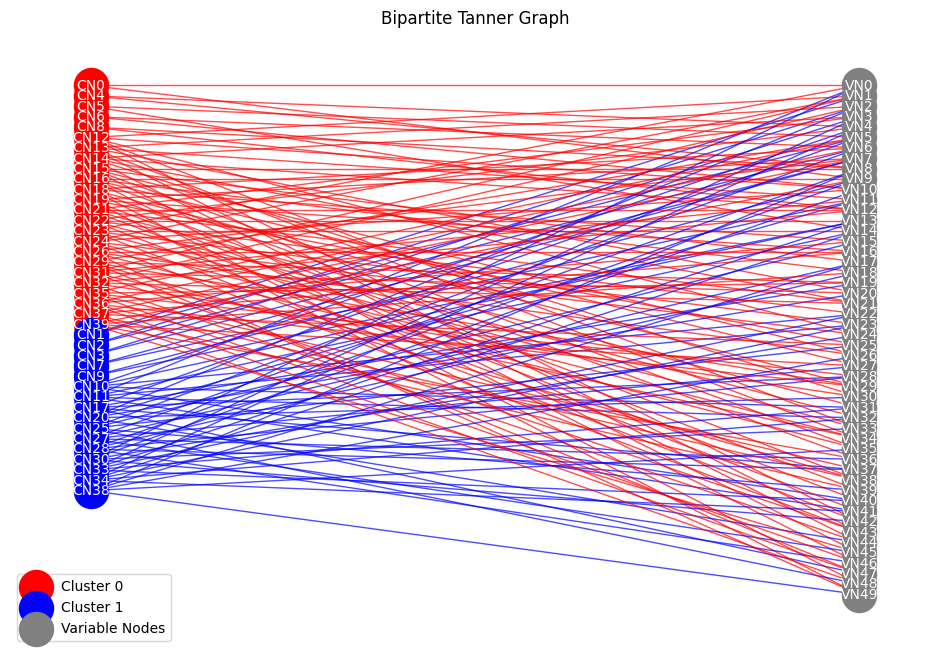

[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]]


In [86]:
visualize_tanner_graph(H, clusters)
print(H)

### Generating snrdbs for episodes

In [87]:
min_snrdb = 1.5
max_snrdb = 1.5
EPISODES = 150
num_iter = 150
# cluster_size = 20 # keeping 2 clusters

# time as additional dimension in state
state_dim = num_clusters
print(f"{num_clusters} clusters")
print("Clusters are:")
for i, cluster in enumerate(clusters):
    print(f"Cluster {i}: {cluster}")

action_dim = num_clusters
verbose = "off"

snrdb_vals = np.random.uniform(min_snrdb, max_snrdb, EPISODES)


2 clusters
Clusters are:
Cluster 0: [0, 4, 5, 6, 8, 12, 13, 14, 15, 16, 18, 19, 21, 22, 23, 24, 26, 29, 31, 32, 35, 36, 37, 39]
Cluster 1: [1, 2, 3, 7, 9, 10, 11, 17, 20, 25, 27, 28, 30, 33, 34, 38]


In [88]:
# min_snrdb = 1.5
# max_snrdb = 1.5
# EPISODES = 600
# num_iter = 150
# cluster_size = 20 # keeping 2 clusters
# num_clusters = math.ceil(H.shape[0]/cluster_size)

# # time as additional dimension in state
# state_dim = num_clusters
# print(f"{num_clusters} clusters")

# action_dim = num_clusters
# verbose = "off"

# snrdb_vals = np.random.uniform(min_snrdb, max_snrdb, EPISODES)


In [89]:
# num_CN = H.shape[0]
# num_clusters = math.ceil(num_CN/cluster_size)
# MI = np.zeros(num_clusters)

# clusters = []
# for i in np.arange(0,num_CN,cluster_size):
#     temp = []
#     for j in range(i,min(i+cluster_size,num_CN)):
#         temp.append(j)
#     clusters.append(temp)  


# print("Clusters are \n")
# for i,l in enumerate(clusters):
#     print(f"cluster {i} : {l}")


In [90]:
average_threshold = 0.5

def MI_stopping_criteria(MI):
    # if np.sum(MI)/len(MI)>=average_threshold:
    #     return True
    return False

## State as diff in MI (current and prev)

In [97]:
# Main training loop
agent = DQNAgent(state_dim=state_dim, action_dim=action_dim, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.8, epsilon_min=0.01, batch_size=128, buffer_size=1000)

print_once = True
score_list = []

# states for which track of Q(s,a) values is kept (for all actions)
const_state1 = np.array([0.0,0.8])
const_state2 = np.array([0.75,0.0])
const_state3 = np.array([0.05,0.01])

# const_state1 = np.array([0.0,0.8,0.1,0.01, 0.6, 0.0])
# const_state2 = np.array([0.75,0.0,0.01,0.01,0.01, 0.0])
# const_state3 = np.array([0.05,0.1,0.05, 0.1,0.0, 0.0])

# const_state1 = np.array([0.0,0.8,0.1])
# const_state2 = np.array([0.75,0.0,0.01])
# const_state3 = np.array([0.05,0.1,0.05])

# Q(s,a) values for the above states
ar = []
count = 0
result1 = []
result2 = []
result3 = []

failure = []
success = []

a1 = []
a2 = []

neg_states = []

for EP in range(EPISODES):
    # getting a random codeword and a random snr and adding noise to it
    snrdb = snrdb_vals[EP]
    snr = math.pow(10,snrdb/20)
    c = C[np.random.choice(len(C))] # correct codeword
    sigma = 1/math.sqrt(snr)
    y = np.power(- 1,c) + np.random.normal(loc=0, scale=sigma, size=c.shape) # noisy codeword
    
    # creating decoder instance and initializing the decoder (setting up initial state)
    dec = Decoder(H,num_iter,cluster_size, clusters=None)
    dec.sum = y
    dec.L = np.full(dec.H.shape, np.nan, dtype=float)
    for i in range(dec.num_CN):
        for j in range(dec.num_VN):
            dec.L[i,j] = 0 if dec.H[i,j]==1 else np.nan
    dec.MI = dec.get_MI(dec.L)

    previous_MI = np.zeros(num_clusters)
    state = dec.MI-previous_MI
    if(state[0]<0 or state[1]<0):
        neg_states.append(state)
    # state = np.append(state,0)
    previous_MI = dec.MI
    # state = dec.MI

    
    # print(f"Starting state of episode : {state}")
    score, done = 0.0, False

    decoding_complete = False
    timestep = 0
    b1 = []
    b2 = []
    while not done:
        b1.append(state[0])
        b2.append(state[1])
        if(state[0]<0 or state[1]<0):
            neg_states.append(state)
        epsilon = max(0.1, 0.9 - 0.01 * EP)  # Linearly anneal epsilon
        # agent.lr = 0.1*(0.9**EP)  # Linearly anneal epsilon
        action = agent.choose_action(state)
        if verbose=="on":
            print("===============================================================")
            print("Iteration : ",EP,timestep,"\nAction chosen : ",action)

        # print(f"Current state = {state}",end="\n")
        # print(f"Action = {action}",end="\n")
        # Do one decoder iteration (s,a -> s',r)
        dec.row_update(action)
        dec.col_update(action)
        # get the next state
        dec.MI = dec.get_MI(dec.L)
        next_state = dec.MI-previous_MI
        previous_MI = dec.MI
        # next_state = dec.MI
        
        # print(f"reward collected : {reward}")
        c_hat = np.array([1 if val<0 else 0 for val in dec.sum])
        
        reward = (np.sum(c == c_hat)/len(c))
        # p_L, p_sum = dec.pseudo_row_update(action)
        # reward = (dec.get_MI(p_L)-dec.MI)[action]
        # print(f"Reward = {reward}",end="\n")
        # print(f"Next_State = {next_state}",end="\n")
        
        if dec.stopping_criteria(timestep, c_hat) or MI_stopping_criteria(next_state):
            if timestep==num_iter+1:
                count+=1
                # print(f"F: Final MI values : {dec.MI}\t and sum = {np.sum(dec.MI)}")
                failure.append(next_state)
            ar.append(count/(EP+1))
            if timestep<num_iter+1:
                reward+=(100*(0.99**timestep))
                # print(f"S: Final MI values : {dec.MI}\t and sum = {np.sum(dec.MI)}")
                success.append(next_state)
                decoding_complete = True
            done = True
#             reward += 100
    
    
        agent.memorize(state, action, reward, next_state, done)
        agent.train_agent(timestep)

        score += reward
        state = next_state
        # state = np.append(state,timestep+1)

        if len(agent.memory.buffer) == agent.batch_size:
            if print_once:
                print("Training started!")
            print_once = False
        timestep = timestep + 1

    const_state_tensor1 = torch.tensor(const_state1, dtype=torch.float32).unsqueeze(0).to(agent.device)
    with torch.no_grad():  # Disable gradient computation
        q_values = agent.policy_net(const_state_tensor1)
        # print("Q(s,a) = {:.3f}".format(q_values))
        # print(q_values)
        # optimal_action = torch.argmax(q_values).item()  # Get the index of the max Q-value
        vall = q_values.detach().cpu().numpy()
        result1.append(vall.copy())
    const_state_tensor2 = torch.tensor(const_state2, dtype=torch.float32).unsqueeze(0).to(agent.device)
    with torch.no_grad():  # Disable gradient computation
        q_values = agent.policy_net(const_state_tensor2)
        # print("Q(s,a) = {:.3f}".format(q_values))
        # print(q_values)
        # optimal_action = torch.argmax(q_values).item()  # Get the index of the max Q-value
        vall = q_values.detach().cpu().numpy()
        result2.append(vall.copy())
    const_state_tensor3 = torch.tensor(const_state3, dtype=torch.float32).unsqueeze(0).to(agent.device)
    with torch.no_grad():  # Disable gradient computation
        q_values = agent.policy_net(const_state_tensor3)
        # print("Q(s,a) = {:.3f}".format(q_values))
        # print(q_values)
        # optimal_action = torch.argmax(q_values).item()  # Get the index of the max Q-value
        vall = q_values.detach().cpu().numpy()
        result3.append(vall.copy())
    # if decoding_complete:
    #     score+=(100)
    print("EP:{}, snrdB={:.2f} Avg_Score:{:.3f}, Total:{:.3f}, ts:{:1f}".format(EP,snrdb, score/timestep, score, timestep), end=" ")
    if timestep<num_iter+2:
        print('\u2713')
    else:
        print()
    score_list.append(score/timestep)
    a1.append(b1)
    a2.append(b2)


EP:0, snrdB=1.50 Avg_Score:12.541, Total:100.327, ts:8.000000 ✓
Training started!
EP:1, snrdB=1.50 Avg_Score:0.702, Total:106.660, ts:152.000000 
EP:2, snrdB=1.50 Avg_Score:0.940, Total:142.880, ts:152.000000 
EP:3, snrdB=1.50 Avg_Score:0.921, Total:139.980, ts:152.000000 
EP:4, snrdB=1.50 Avg_Score:50.480, Total:100.960, ts:2.000000 ✓
EP:5, snrdB=1.50 Avg_Score:0.945, Total:143.640, ts:152.000000 
EP:6, snrdB=1.50 Avg_Score:0.900, Total:136.800, ts:152.000000 
EP:7, snrdB=1.50 Avg_Score:0.839, Total:127.500, ts:152.000000 
EP:8, snrdB=1.50 Avg_Score:0.822, Total:124.880, ts:152.000000 
EP:9, snrdB=1.50 Avg_Score:25.117, Total:100.470, ts:4.000000 ✓
EP:10, snrdB=1.50 Avg_Score:50.490, Total:100.980, ts:2.000000 ✓
EP:11, snrdB=1.50 Avg_Score:100.960, Total:100.960, ts:1.000000 ✓
EP:12, snrdB=1.50 Avg_Score:0.780, Total:118.560, ts:152.000000 
EP:13, snrdB=1.50 Avg_Score:0.958, Total:145.620, ts:152.000000 
EP:14, snrdB=1.50 Avg_Score:0.900, Total:136.740, ts:152.000000 
EP:15, snrdB=1.5

KeyboardInterrupt: 

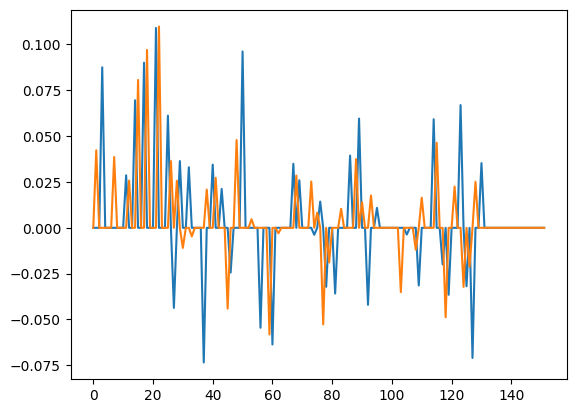

In [ ]:
i = 1
plt.plot(a1[i])
plt.plot(a2[i])
plt.show()

## State as diff in MI (pseudo)

In [ ]:
# Main training loop
agent = DQNAgent(state_dim=state_dim, action_dim=action_dim, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.8, epsilon_min=0.01, batch_size=128, buffer_size=1000)

print_once = True
score_list = []

# states for which track of Q(s,a) values is kept (for all actions)
# const_state1 = np.array([0.0,0.8])
# const_state2 = np.array([0.75,0.0])
# const_state3 = np.array([0.05,0.1])

# const_state1 = np.array([0.0,0.8,0.1,0.01, 0.6, 0.0])
# const_state2 = np.array([0.75,0.0,0.01,0.01,0.01, 0.0])
# const_state3 = np.array([0.05,0.1,0.05, 0.1,0.0, 0.0])

const_state1 = np.array([0.0,0.8,0.1])
const_state2 = np.array([0.75,0.0,0.01])
const_state3 = np.array([0.05,0.1,0.05])

# Q(s,a) values for the above states
ar = []
count = 0
result1 = []
result2 = []
result3 = []

failure = []
success = []

neg_states = []

for EP in range(EPISODES):
    # getting a random codeword and a random snr and adding noise to it
    snrdb = snrdb_vals[EP]
    snr = math.pow(10,snrdb/20)
    c = C[np.random.choice(len(C))] # correct codeword
    sigma = 1/math.sqrt(snr)
    y = np.power(- 1,c) + np.random.normal(loc=0, scale=sigma, size=c.shape) # noisy codeword
    
    # creating decoder instance and initializing the decoder (setting up initial state)
    dec = Decoder(H,num_iter,cluster_size, clusters=None)
    dec.sum = y
    dec.L = np.full(dec.H.shape, np.nan, dtype=float)
    for i in range(dec.num_CN):
        for j in range(dec.num_VN):
            dec.L[i,j] = 0 if dec.H[i,j]==1 else np.nan
    dec.MI = dec.get_MI(dec.L)

    # returns the state given decoder
    def get_pseudo_difference_MI(dec):
        dec.MI = dec.get_MI(dec.L)
        MI_gains = np.zeros(dec.num_clusters)
        for a in range(dec.num_clusters):
            p_L, p_sum = dec.pseudo_row_update(a)
            MI_new = dec.get_MI(p_L)
            gain = dec.calculate_residual(dec.MI, MI_new, a)
            MI_gains[a] = gain
        
        return MI_gains

    state = get_pseudo_difference_MI(dec)
    print(f"Starting state of episode : {state}")

    if(state[0]<0 or state[1]<0):
        neg_states.append(state)

    score, done = 0.0, False

    decoding_complete = False
    timestep = 0
    while not done:
        if(state[0]<0 or state[1]<0):
            neg_states.append(state)
        epsilon = max(0.1, 0.9 - 0.01 * EP)  # Linearly anneal epsilon
        # agent.lr = 0.1*(0.9**EP)  # Linearly anneal epsilon
        action = agent.choose_action(state)
        if verbose=="on":
            print("===============================================================")
            print("Iteration : ",EP,timestep,"\nAction chosen : ",action)

        print(f"Current state = {state}",end="\n")
        print(f"Action = {action}",end="\n")
        
        # Do one decoder iteration (s,a -> s',r)
        dec.row_update(action)
        dec.col_update(action)
        
        # get the next state
        next_state = get_pseudo_difference_MI(dec)
        
        # print(f"reward collected : {reward}")
        c_hat = np.array([1 if val<0 else 0 for val in dec.sum])
        
        # reward = (np.sum(c == c_hat)/len(c))
        reward = state[action]
        print(f"Reward = {reward}",end="\n")
        print(f"Next_State = {next_state}",end="\n")
        
        if dec.stopping_criteria(timestep, c_hat) or MI_stopping_criteria(next_state):
            if timestep==num_iter+1:
                count+=1
                # print(f"F: Final MI values : {dec.MI}\t and sum = {np.sum(dec.MI)}")
                failure.append(next_state)
            ar.append(count/(EP+1))
            if timestep<num_iter+1:
                reward+=(100*(0.99**timestep))
                # print(f"S: Final MI values : {dec.MI}\t and sum = {np.sum(dec.MI)}")
                success.append(next_state)
                decoding_complete = True
            done = True
#             reward += 100
    
    
        agent.memorize(state, action, reward, next_state, done)
        agent.train_agent(timestep)

        score += reward
        state = next_state
        # state = np.append(state,timestep+1)

        if len(agent.memory.buffer) == agent.batch_size:
            if print_once:
                print("Training started!")
            print_once = False
        timestep = timestep + 1

    const_state_tensor1 = torch.tensor(const_state1, dtype=torch.float32).unsqueeze(0).to(agent.device)
    with torch.no_grad():  # Disable gradient computation
        q_values = agent.policy_net(const_state_tensor1)
        # print("Q(s,a) = {:.3f}".format(q_values))
        # print(q_values)
        # optimal_action = torch.argmax(q_values).item()  # Get the index of the max Q-value
        vall = q_values.detach().cpu().numpy()
        result1.append(vall.copy())
    const_state_tensor2 = torch.tensor(const_state2, dtype=torch.float32).unsqueeze(0).to(agent.device)
    with torch.no_grad():  # Disable gradient computation
        q_values = agent.policy_net(const_state_tensor2)
        # print("Q(s,a) = {:.3f}".format(q_values))
        # print(q_values)
        # optimal_action = torch.argmax(q_values).item()  # Get the index of the max Q-value
        vall = q_values.detach().cpu().numpy()
        result2.append(vall.copy())
    const_state_tensor3 = torch.tensor(const_state3, dtype=torch.float32).unsqueeze(0).to(agent.device)
    with torch.no_grad():  # Disable gradient computation
        q_values = agent.policy_net(const_state_tensor3)
        # print("Q(s,a) = {:.3f}".format(q_values))
        # print(q_values)
        # optimal_action = torch.argmax(q_values).item()  # Get the index of the max Q-value
        vall = q_values.detach().cpu().numpy()
        result3.append(vall.copy())
    # if decoding_complete:
    #     score+=(100)
    print("EP:{}, snrdB={:.2f} Avg_Score:{:.3f}, Total:{:.3f}, ts:{:1f}".format(EP,snrdb, score/timestep, score, timestep), end=" ")
    if timestep<num_iter+2:
        print('\u2713')
    else:
        print()
    score_list.append(score/timestep)


Starting state of episode : [0.28369731 0.17018804 0.12684606]
Current state = [0.28369731 0.17018804 0.12684606]
Action = 2
Reward = 0.1268460576038845
Next_State = [ 0.0598844  -0.08962452 -0.16486591]
Current state = [ 0.0598844  -0.08962452 -0.16486591]
Action = 0
Reward = 0.05988439753455438
Next_State = [0.         0.11697328 0.2438375 ]
Current state = [0.         0.11697328 0.2438375 ]
Action = 2
Reward = 0.24383749890021886
Next_State = [0.23913007 0.11125833 0.00781922]
Current state = [0.23913007 0.11125833 0.00781922]
Action = 0
Reward = 0.23913006659505875
Next_State = [0.         0.62827911 0.10443873]
Current state = [0.         0.62827911 0.10443873]
Action = 2
Reward = 0.10443872637326979
Next_State = [0.         0.06213877 0.        ]
Current state = [0.         0.06213877 0.        ]
Action = 1
Reward = 0.06213876876221647
Next_State = [0. 0. 0.]
Current state = [0. 0. 0.]
Action = 0
Reward = 0.0
Next_State = [0. 0. 0.]
Current state = [0. 0. 0.]
Action = 0
Reward = 

KeyboardInterrupt: 

In [71]:
print(len(neg_states),' negative states\n')

62  negative states



In [62]:

if state_dim==2:
    # Unpacking x and y coordinates for scatter plot
    S_x, S_y = zip(*success)
    F_x, F_y = zip(*failure)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(S_x, S_y, color='green', label='Success', marker='o')
    plt.scatter(F_x, F_y, color='red', label='Failure', marker='x')

    # Adding labels, legend, and grid
    plt.title('Scatter Plot of S and F with state = MI_vector')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.grid(True)
    plt.show()


In [63]:
import numpy as np
import torch
from mpl_toolkits.mplot3d import Axes3D

if state_dim==2:
    # Define a grid of states for plotting
    state_x = np.linspace(0, 1, 50)  # Range for state dimension 1
    state_y = np.linspace(0, 1, 50)  # Range for state dimension 2
    state_grid = np.array([[x, y] for x in state_x for y in state_y])

    # Convert state grid to tensor and compute Q-values
    state_tensor = torch.FloatTensor(state_grid).to(agent.device)  # Assuming agent and agent.policy_net are available
    with torch.no_grad():
        q_values = agent.policy_net(state_tensor)
        q_max_values = q_values.max(1)[0].cpu().numpy()  # Max Q(s) for each state

    # Reshape data for 3D plotting
    X, Y = np.meshgrid(state_x, state_y)
    Z = q_max_values.reshape(X.shape)

    # Plotting
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k', alpha=0.8)

    # Add labels and title
    ax.set_title('Q(s) vs State (s)')
    ax.set_xlabel('State Dimension 1')
    ax.set_ylabel('State Dimension 2')
    ax.set_zlabel('Q(s)')
    fig.colorbar(surf, shrink=0.5, aspect=10)
    plt.show()


In [64]:
import matplotlib.pyplot as plt
import numpy as np
import torch

if state_dim==2:
    # Define a grid of states for plotting
    state_x = np.linspace(0, 1, 50)  # Range for state dimension 1
    state_y = np.linspace(0, 1, 50)  # Range for state dimension 2
    state_grid = np.array([[x, y] for x in state_x for y in state_y])

    # Convert state grid to tensor and compute Q-values
    state_tensor = torch.FloatTensor(state_grid).to(agent.device)
    with torch.no_grad():
        q_values = agent.policy_net(state_tensor)
        q_max_values = q_values.max(1)[0].cpu().numpy()  # Max Q(s) for each state

    # Create the scatter plot with colormap
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        state_grid[:, 0], state_grid[:, 1], c=q_max_values, cmap="viridis", s=50
    )

    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label("Q(s)")

    # Add labels and title
    plt.xlabel("State Dimension 1")
    plt.ylabel("State Dimension 2")
    plt.title("Value function of state (s)")

    # Show the plot
    plt.show()


In [65]:
# # Main training loop

# agent = DQNAgent(state_dim=state_dim, action_dim=action_dim, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.8, epsilon_min=0.01, batch_size=64, buffer_size=1000)

# print_once = True
# score_list = []

# # states for which track of Q(s,a) values is kept (for all actions)
# const_state1 = np.array([0.15,0.8])
# const_state2 = np.array([0.75,0.01])
# const_state3 = np.array([0.05,0.1])


# # Q(s,a) values for the above states
# ar = []
# count = 0
# result1 = []
# result2 = []
# result3 = []


# for EP in range(EPISODES):
#     # getting a random codeword and a random snr and adding noise to it
#     snrdb = snrdb_vals[EP]
#     snr = math.pow(10,snrdb/20)
#     c = C[np.random.choice(len(C))] # correct codeword
#     sigma = 1/math.sqrt(snr)
#     y = np.power(- 1,c) + np.random.normal(loc=0, scale=sigma, size=c.shape) # noisy codeword
    
#     # creating decoder instance and initializing the decoder (setting up initial state)
#     dec = Decoder(H,num_iter,cluster_size)
#     dec.sum = y
#     dec.L = np.full(dec.H.shape, np.nan, dtype=float)
#     for i in range(dec.num_CN):
#         for j in range(dec.num_VN):
#             dec.L[i,j] = 0 if dec.H[i,j]==1 else np.nan
#     dec.MI = dec.get_MI(dec.L)

#     state = np.sum(dec.MI)

    
#     # print(f"Starting state of episode : {state}")
#     score, done = 0.0, False

#     decoding_complete = False
#     timestep = 0
#     while not done:
#         epsilon = max(0.1, 0.9 - 0.01 * EP)  # Linearly anneal epsilon
#         # agent.lr = 0.1*(0.9**EP)  # Linearly anneal epsilon
#         action = agent.choose_action(state)
#         if verbose=="on":
#             print("===============================================================")
#             print("Iteration : ",EP,timestep,"\nAction chosen : ",action)

#         # print(f"Current state = {state}",end="\n")
#         # print(f"Action = {action}",end="\n")
#         # Do one decoder iteration (s,a -> s',r)
#         dec.row_update(action)
#         dec.col_update(action)
#         # get the next state
#         dec.MI = dec.get_MI(dec.L)
#         next_state = np.sum(dec.MI)
        
#         # print(f"reward collected : {reward}")
#         c_hat = np.array([1 if val<0 else 0 for val in dec.sum])
        
#         reward = (np.sum(c == c_hat)/len(c))
#         # p_L, p_sum = dec.pseudo_row_update(action)
#         # reward = (dec.get_MI(p_L)-dec.MI)[action]
#         # print(f"Reward = {reward}",end="\n")
#         # print(f"Next_State = {next_state}",end="\n")
        
#         if dec.stopping_criteria(timestep, c_hat) or MI_stopping_criteria(next_state):
#             if timestep==num_iter+1:
#                 count+=1
#             ar.append(count/(EP+1))
#             if timestep<num_iter+1:
#                 reward+=(100*(0.99**timestep))
#                 decoding_complete = True
#             done = True
# #             reward += 100
    
    
#         agent.memorize(state, action, reward, next_state, done)
#         agent.train_agent(timestep)

#         score += reward
#         state = next_state
#         # state = np.append(state,timestep+1)

#         if len(agent.memory.buffer) == agent.batch_size:
#             if print_once:
#                 print("Training started!")
#             print_once = False
#         timestep = timestep + 1

#     const_state_tensor1 = torch.tensor(const_state1, dtype=torch.float32).unsqueeze(0).to(agent.device)
#     with torch.no_grad():  # Disable gradient computation
#         q_values = agent.policy_net(const_state_tensor1)
#         # print("Q(s,a) = {:.3f}".format(q_values))
#         # print(q_values)
#         # optimal_action = torch.argmax(q_values).item()  # Get the index of the max Q-value
#         vall = q_values.detach().cpu().numpy()
#         result1.append(vall.copy())
#     const_state_tensor2 = torch.tensor(const_state2, dtype=torch.float32).unsqueeze(0).to(agent.device)
#     with torch.no_grad():  # Disable gradient computation
#         q_values = agent.policy_net(const_state_tensor2)
#         # print("Q(s,a) = {:.3f}".format(q_values))
#         # print(q_values)
#         # optimal_action = torch.argmax(q_values).item()  # Get the index of the max Q-value
#         vall = q_values.detach().cpu().numpy()
#         result2.append(vall.copy())
#     const_state_tensor3 = torch.tensor(const_state3, dtype=torch.float32).unsqueeze(0).to(agent.device)
#     with torch.no_grad():  # Disable gradient computation
#         q_values = agent.policy_net(const_state_tensor3)
#         # print("Q(s,a) = {:.3f}".format(q_values))
#         # print(q_values)
#         # optimal_action = torch.argmax(q_values).item()  # Get the index of the max Q-value
#         vall = q_values.detach().cpu().numpy()
#         result3.append(vall.copy())
#     # if decoding_complete:
#     #     score+=(100)
#     print("EP:{}, snrdB={:.2f} Avg_Score:{:.3f}, Total:{:.3f}, ts:{:1f}".format(EP,snrdb, score/timestep, score, timestep), end=" ")
#     if timestep<num_iter+2:
#         print('\u2713')
#     else:
#         print()
#     score_list.append(score/timestep)


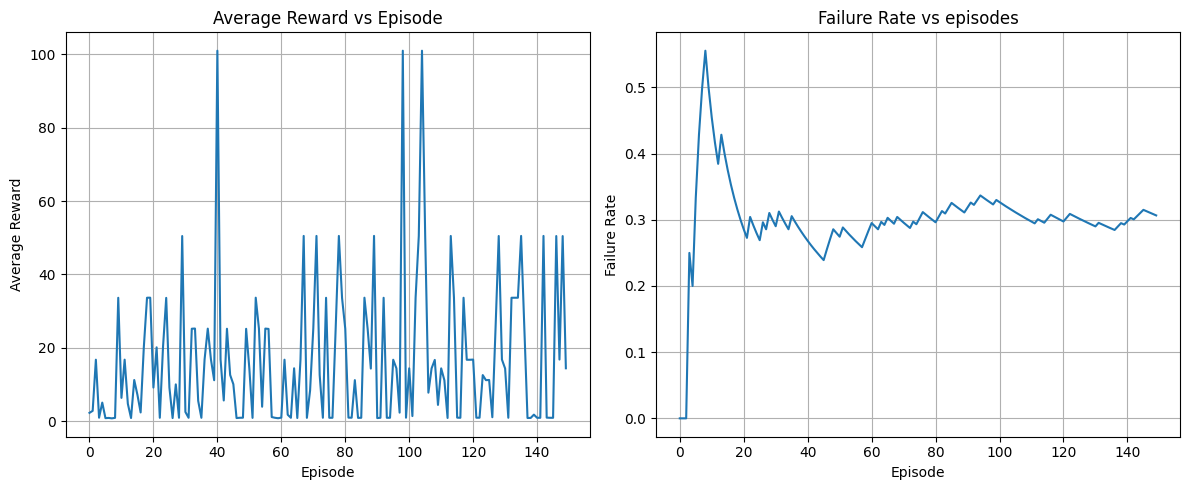

In [66]:
# Draw reward vs episode plot
import matplotlib.pyplot as plt
# Create a figure and a set of subplots with 1 row and 2 columns
plt.figure(figsize=(12, 5))

# Plot the first graph (Average Reward vs Episode)
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(score_list)
plt.grid(True)
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episode')

# Plot the second graph (Epsilon Decay)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(ar)
plt.grid(True)
plt.xlabel('Episode')
plt.ylabel('Failure Rate')
plt.title('Failure Rate vs episodes')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [67]:
result1 = np.array(result1)
# print(result)
# print(result.shape)
results1= np.reshape(result1,(EPISODES,num_clusters))
# print(results1)

result2 = np.array(result2)
# print(result)
# print(result.shape)
results2= np.reshape(result2,(EPISODES,num_clusters))
# print(results2)

result3 = np.array(result3)
# print(result)
# print(result.shape)
results3= np.reshape(result3,(EPISODES,num_clusters))
# print(results3)

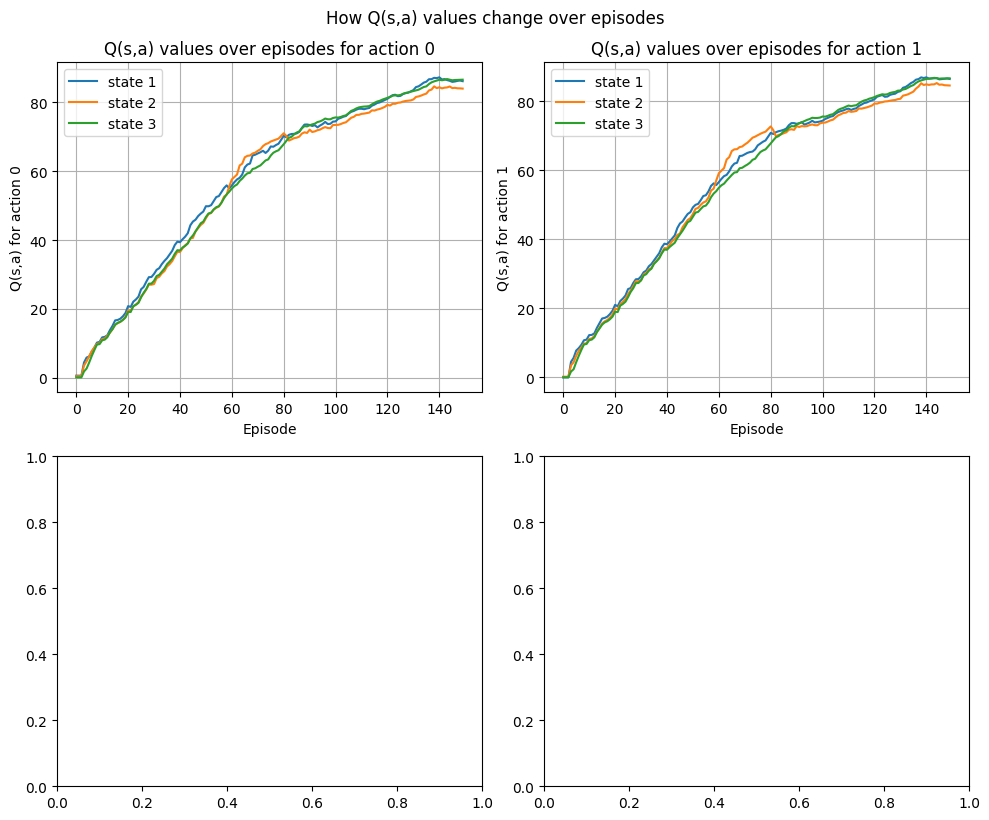

In [68]:
import matplotlib.pyplot as plt

# Assuming results1, results2, results3 are available
# and have appropriate dimensions for plotting.

A = [0, 1]
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for i, a in enumerate(A):
    ax = axes[i // 2, i % 2]  # Select the appropriate subplot
    ax.plot(results1[:, a], label="state 1")
    ax.plot(results2[:, a], label="state 2")
    ax.plot(results3[:, a], label="state 3")
    ax.grid('on')
    ax.set_xlabel('Episode')
    ax.set_ylabel(f'Q(s,a) for action {a}')
    ax.legend()
    ax.set_title(f'Q(s,a) values over episodes for action {a}')

plt.tight_layout()
plt.suptitle('How Q(s,a) values change over episodes', y=1.02)
plt.show()


[0.61919105 0.61919105 0.61919105 4.435378   5.8837485 ]
[3.2272488e-03 3.2272488e-03 3.2272488e-03 4.5042496e+00 5.6682520e+00]
[0.37001655 0.37001655 0.37001655 3.6261153  5.3989344 ]

[0.45121485 0.45121485 0.45121485 3.5708995  4.791025  ]
[0.203129  0.203129  0.203129  3.4838572 4.3935356]
[0.53904843 0.53904843 0.53904843 3.3636565  4.8325167 ]

[0.11045284 0.11045284 0.11045284 1.8295288  2.6944354 ]
[0.0541281 0.0541281 0.0541281 1.7036506 2.3642988]
[0.04227003 0.04227003 0.04227003 1.5025556  2.4423435 ]



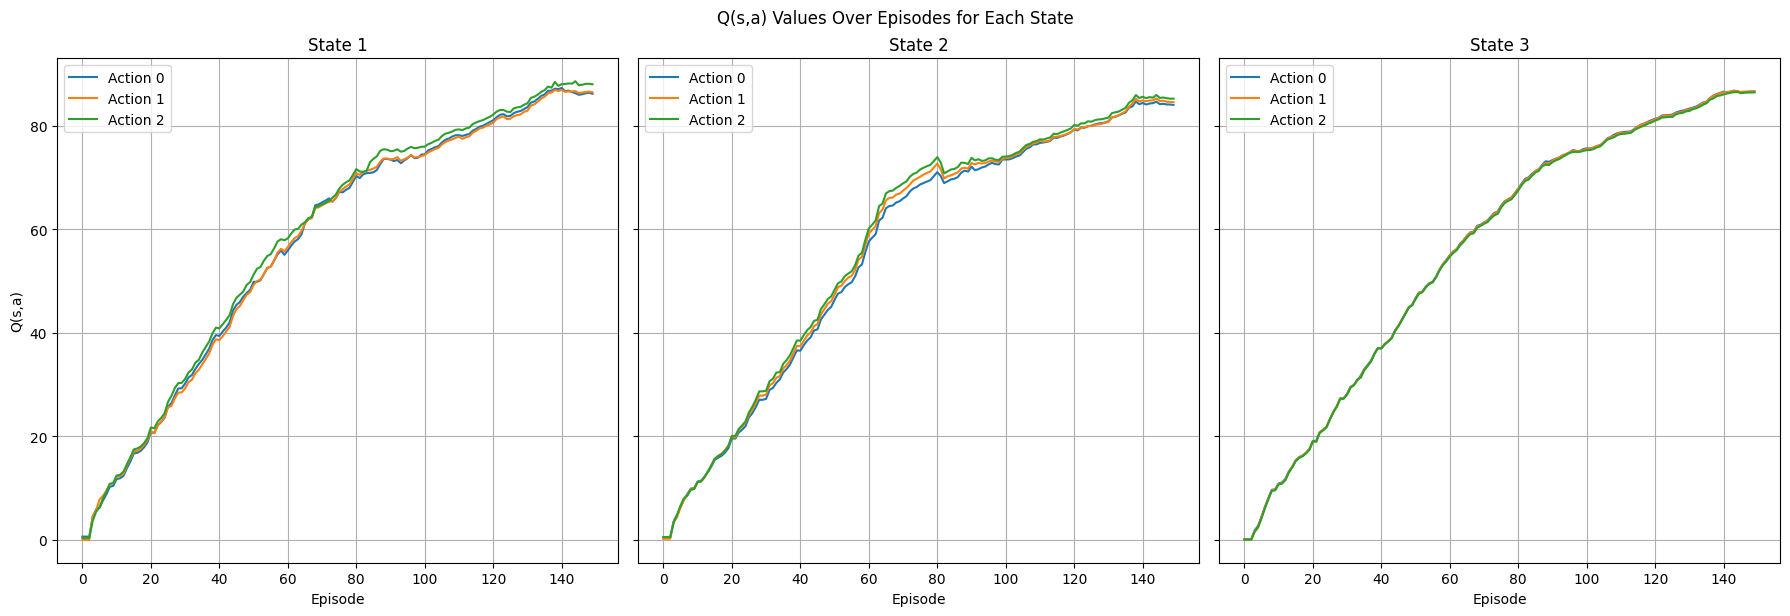

In [69]:
import matplotlib.pyplot as plt

# Assuming results1, results2, and results3 are numpy arrays with appropriate dimensions
# Each has shape (num_episodes, num_actions)

actions = np.arange(num_clusters)
states = [results1, results2, results3]
state_labels = ["State 1", "State 2", "State 3"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # 1 row, 3 columns, shared y-axis

for i, (state, label) in enumerate(zip(states, state_labels)):
    ax = axes[i]  # Select the appropriate subplot
    for a in actions:
        ax.plot(state[:, a], label=f"Action {a}")  # Plot Q(s,a) for each action
        print(state[:, a][0:5])
    ax.grid('on')
    ax.set_xlabel('Episode')
    ax.set_title(label)
    if i == 0:
        ax.set_ylabel('Q(s,a)')
    ax.legend()
    print()

plt.tight_layout()
plt.suptitle('Q(s,a) Values Over Episodes for Each State', y=1.02)
plt.show()


In [72]:
variables = {
    "snrdb_range": [min_snrdb,max_snrdb],
    "Number of episodes": EPISODES,
    "Max iters per episode": num_iter,
    "Cluster Size": cluster_size,
    "Learning rate":agent.lr,
    "Discount factor":agent.gamma,
    "Epsilon decay":agent.epsilon_decay,
    "Batch size":agent.batch_size,
    "Base Matrix\n":B,
    "Architecture\n":agent.policy_net,
    "States\n":np.array([const_state1,const_state2,const_state3])
}

# Save variables to a text file
with open("agents/temp.txt", "w") as file:
    for name, value in variables.items():
        file.write(f"{name} = {value}\n")

print("Variables saved to 'agents/temp.txt'")


Variables saved to 'agents/temp.txt'


### Saving the model and noting down the parameters

In [ ]:
save_model(agent.policy_net, "./agents/policy_net.pth")

variables = {
    "snrdb_range": [min_snrdb,max_snrdb],
    "Number of episodes": EPISODES,
    "Max iters per episode": num_iter,
    "Cluster Size": cluster_size,
    "Learning rate":agent.lr,
    "Discount factor":agent.gamma,
    "Epsilon decay":agent.epsilon_decay,
    "Batch size":agent.batch_size,
    "Base Matrix\n":B,
    "Architecture\n":agent.policy_net,
    "States\n":np.array([const_state1,const_state2,const_state3])
}
# Save variables to a text file
with open("agents/params.txt", "w") as file:
    for name, value in variables.items():
        file.write(f"{name} = {value}\n")

print("Variables saved to 'agents/params.txt'")


Model saved to ./agents/policy_net.pth
Variables saved to 'agents/params.txt'


## Evaluating Greedy Policy

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the Q-network (same as provided)
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, action_dim)

        # Explicit weight initialization
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc1.bias)
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_uniform_(self.fc3.weight)  # Output layer: Xavier Uniform for final layer
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the RL agent
class RLAgent:
    def __init__(self, state_dim, action_dim, gamma=0.9, lr=1e-3):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma

        # Q-network and target network
        self.q_net = DQN(state_dim, action_dim)
        self.target_net = DQN(state_dim, action_dim)
        self.target_net.load_state_dict(self.q_net.state_dict())

        # Optimizer and loss function
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

    def get_action(self, state, epsilon=0.1):
        if np.random.rand() < epsilon:
            return np.random.randint(self.action_dim)  # Random action
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                q_values = self.q_net(state_tensor)
                return torch.argmax(q_values).item()  # Greedy action

    def train(self, state, action, reward, next_state, done):
        # Convert to tensors
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
        action_tensor = torch.LongTensor([action])
        reward_tensor = torch.FloatTensor([reward])

        # Compute Q-values
        current_q = self.q_net(state_tensor).gather(1, action_tensor.unsqueeze(1))
        next_q = self.target_net(next_state_tensor).max(1)[0].detach()
        target_q = reward_tensor + (1 - done) * self.gamma * next_q

        # Compute loss and update Q-network
        loss = self.loss_fn(current_q, target_q.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_net.load_state_dict(self.q_net.state_dict())

# Training loop
def train_rl_agent(decoder, agent, num_episodes=1000, epsilon=0.1):
    for episode in range(num_episodes):
        state = decoder.get_MI(decoder.L)  # Initial state (MI vector)
        done = False

        while not done:
            action = agent.get_action(state, epsilon)  # Choose action
            # Simulate scheduling the cluster and get reward
            reward, next_state = simulate_scheduling(decoder, action)
            done = decoder.stopping_criteria(decoder.iteration_number, decoder.sum)

            # Train the agent
            agent.train(state, action, reward, next_state, done)

            # Update state
            state = next_state

        # Update target network
        if episode % 10 == 0:
            agent.update_target_network()

# Simulate scheduling a cluster
def simulate_scheduling(decoder, action):
    # Perform row and column updates for the selected cluster
    decoder.row_update(action)
    decoder.col_update(action)

    # Compute new MI vector
    next_state = decoder.get_MI(decoder.L)

    # Compute reward (increase in MI for the scheduled cluster)
    reward = next_state[action] - decoder.MI[action]

    return reward, next_state

# Visualization (for 2D state space)
def visualize_q_values(agent, state_range=(-5, 5), num_points=50):
    if agent.state_dim != 2:
        print("Visualization is only supported for 2D state space.")
        return

    # Create a grid of states
    x = np.linspace(state_range[0], state_range[1], num_points)
    y = np.linspace(state_range[0], state_range[1], num_points)
    X, Y = np.meshgrid(x, y)
    states = np.stack([X.ravel(), Y.ravel()], axis=-1)

    # Compute Q-values for each state
    q_values = []
    with torch.no_grad():
        for state in states:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values.append(agent.q_net(state_tensor).max().item())
    q_values = np.array(q_values).reshape(X.shape)

    # Plot 3D surface
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot_surface(X, Y, q_values, cmap='viridis')
    ax1.set_xlabel('State 1')
    ax1.set_ylabel('State 2')
    ax1.set_zlabel('Q-value')
    ax1.set_title('Q-values (3D Surface)')

    # Plot 2D colormap
    ax2 = fig.add_subplot(122)
    contour = ax2.contourf(X, Y, q_values, levels=50, cmap='viridis')
    plt.colorbar(contour, ax=ax2, label='Q-value')
    ax2.set_xlabel('State 1')
    ax2.set_ylabel('State 2')
    ax2.set_title('Q-values (Colormap)')

    plt.tight_layout()
    plt.show()

# Example usage
# Initialize decoder and RL agent
# H = np.random.randint(2, size=(10, 20))  # Example parity-check matrix
decoder = Decoder(H, num_iter, cluster_size, clusters=None)
decoder.sum = y
decoder.L = np.full(decoder.H.shape, np.nan, dtype=float)  # Initialize with NaNs
for i in range(decoder.num_CN):
    for j in range(decoder.num_VN):
        decoder.L[i,j] = 0 if decoder.H[i,j]==1 else np.nan
    
# initial MI approximation
decoder.MI = decoder.get_MI(decoder.L)

agent = RLAgent(state_dim=decoder.num_clusters, action_dim=decoder.num_clusters)

# Train the agent
train_rl_agent(decoder, agent, num_episodes=1000)

# Visualize Q-values (if state_dim == 2)
visualize_q_values(agent)